In [4]:
cd ..

c:\Users\shish\Purdue\First Sem\Independent Study\Final_Proj_SM\Github_Proj\SoMoBoost


In [5]:
# Define the headers
headers = [
    "WBANNO", "LST_DATE", "CRX_VN", "LONGITUDE", "LATITUDE", "T_DAILY_MAX", "T_DAILY_MIN",
    "T_DAILY_MEAN", "T_DAILY_AVG", "P_DAILY_CALC", "SOLARAD_DAILY", "SUR_TEMP_DAILY_TYPE",
    "SUR_TEMP_DAILY_MAX", "SUR_TEMP_DAILY_MIN", "SUR_TEMP_DAILY_AVG", "RH_DAILY_MAX",
    "RH_DAILY_MIN", "RH_DAILY_AVG", "SOIL_MOISTURE_5_DAILY", "SOIL_MOISTURE_10_DAILY",
    "SOIL_MOISTURE_20_DAILY", "SOIL_MOISTURE_50_DAILY", "SOIL_MOISTURE_100_DAILY",
    "SOIL_TEMP_5_DAILY", "SOIL_TEMP_10_DAILY", "SOIL_TEMP_20_DAILY", "SOIL_TEMP_50_DAILY",
    "SOIL_TEMP_100_DAILY"
]

# Open the input text file and the output CSV file
with open("Datasets\Insitu_SM_2024_ILINKS.txt", "r") as infile, open("Datasets\Insitu_SM_2024_ILINKS.txtInsitu_SM_2024_ILINKS.csv", "w") as outfile:
    # Write the headers to the CSV file
    outfile.write(",".join(headers) + "\n")
    
    # Write the rest of the data from the text file to the CSV file
    for line in infile:
        outfile.write(",".join(line.split()) + "\n")  # Replace spaces with commas for CSV format

In [6]:
import pandas as pd

# Load the data into a pandas DataFrame
df = pd.read_csv("Datasets/Insitu_SM_2024_ILINKS.csv")

# Replace -99.000 and -9999.0 with NaN
df.replace([-99.000, -9999.0], pd.NA, inplace=True)

# Drop rows with NaN values
df_cleaned = df.dropna()

# Drop the rows if Latitude and Longitude are -100.96 38.87
df_cleaned = df_cleaned[~((df_cleaned['LATITUDE'] == 38.87) & (df_cleaned['LONGITUDE'] == -100.96))]

# Display the cleaned DataFrame
print(df_cleaned)

      WBANNO  LST_DATE  CRX_VN  LONGITUDE  LATITUDE T_DAILY_MAX T_DAILY_MIN  \
0      54808  20240101   2.622     -88.37     40.05         2.1        -1.6   
1      54808  20240102   2.622     -88.37     40.05         3.6        -3.9   
2      54808  20240103   2.622     -88.37     40.05         0.5        -4.4   
3      54808  20240104   2.622     -88.37     40.05         2.9        -4.9   
4      54808  20240105   2.622     -88.37     40.05         2.6        -5.7   
...      ...       ...     ...        ...       ...         ...         ...   
2557   63838  20241227   2.622     -84.75     38.09        12.5         3.7   
2558   63838  20241228   2.622     -84.75     38.09        15.6        11.2   
2559   63838  20241229   2.622     -84.75     38.09        15.7         7.5   
2560   63838  20241230   2.622     -84.75     38.09        12.2         6.2   
2561   63838  20241231   2.622     -84.75     38.09        12.2         3.7   

     T_DAILY_MEAN T_DAILY_AVG P_DAILY_CALC  ... SOI

In [7]:
df_cleaned.to_csv("Datasets/cleaned_Insitu_SM_2024_ILINKS.csv", index=False)

,LONGITUDE,LATITUDE,geometry
0,-88.37,40.05,POINT (-88.37000 40.05000)
732,-86.57,38.89,POINT (-86.57000 38.89000)
1843,-86.23,37.25,POINT (-86.23000 37.25000)
2196,-84.75,38.09,POINT (-84.75000 38.09000)


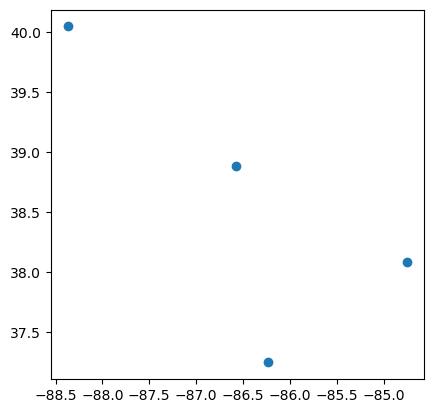

In [9]:
import geopandas as gpd
from shapely.geometry import Point

# Extract unique LONGITUDE and LATITUDE values
unique_coords = df_cleaned[['LONGITUDE', 'LATITUDE']].drop_duplicates()

# Create a GeoDataFrame with WGS 1984 projection
geometry = [Point(xy) for xy in zip(unique_coords['LONGITUDE'], unique_coords['LATITUDE'])]
geo_df = gpd.GeoDataFrame(unique_coords, geometry=geometry, crs="EPSG:4326")

# Save the GeoDataFrame as a shapefile
geo_df.to_file("Datasets/unique_coords.shp", driver="ESRI Shapefile")

#Display the GeoDataFrame on a map
geo_df.plot()
geo_df

In [10]:
import folium
import geopandas as gpd

# Assume geo_df is already defined (unique_coords converted to GeoDataFrame with columns 'LATITUDE' and 'LONGITUDE')
# Create a Folium map (centered at the mean location)
center = [geo_df['LATITUDE'].mean(), geo_df['LONGITUDE'].mean()]
m = folium.Map(location=center, zoom_start=6, tiles="OpenStreetMap")

# Loop over every row and add a marker with a permanent label using DivIcon
for idx, row in geo_df.iterrows():
    label = f"Lat: {row['LATITUDE']}, Lon: {row['LONGITUDE']}"
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        icon=folium.DivIcon(
            html=f"""<div style="display:inline-block; white-space:nowrap; font-size: 12px; color: red; background-color: white; border: 1px solid red; padding: 2px;">{label}</div>"""
        )
    ).add_to(m)

m

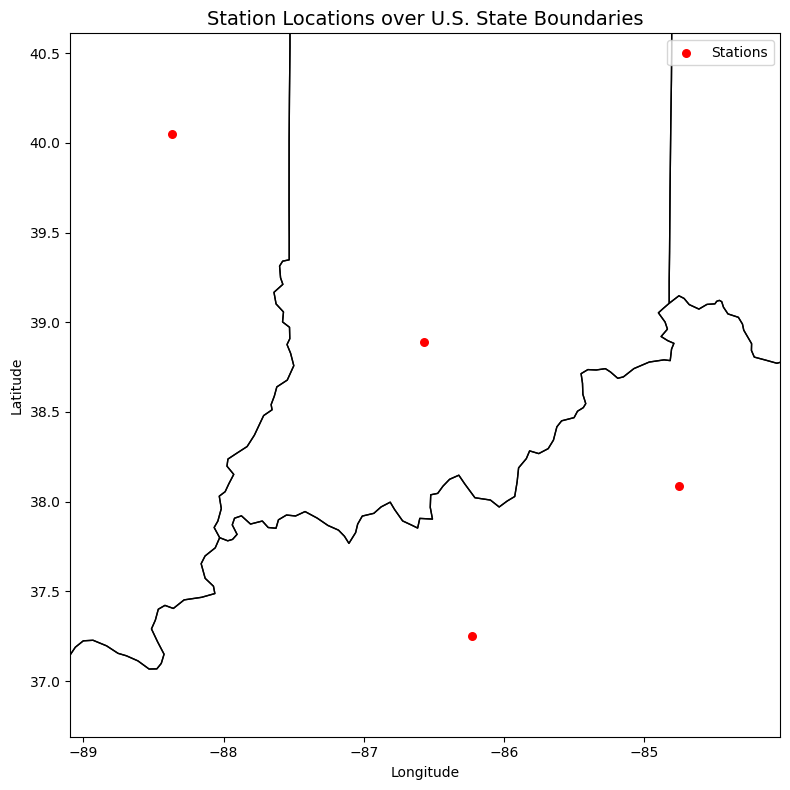

In [12]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Step 1: Create GeoDataFrame for your points
unique_coords = df_cleaned[['LONGITUDE', 'LATITUDE']].drop_duplicates()
geometry = [Point(xy) for xy in zip(unique_coords['LONGITUDE'], unique_coords['LATITUDE'])]
geo_df = gpd.GeoDataFrame(unique_coords, geometry=geometry, crs="EPSG:4326")

# Step 2: Load U.S. states shapefile
states = gpd.read_file("Datasets/cb_2022_us_state_20m.shp")
states = states.to_crs(geo_df.crs)

# OPTIONAL: Remove Alaska, Hawaii, Puerto Rico (keep lower 48 states only)
exclude_states = ['Alaska', 'Hawaii', 'Puerto Rico']
states = states[~states['NAME'].isin(exclude_states)]

# Step 3: Get extent of points and add buffer
minx, miny, maxx, maxy = geo_df.total_bounds
buffer_x = (maxx - minx) * 0.2   # 20% buffer for better look
buffer_y = (maxy - miny) * 0.2

# Step 4: Plot
fig, ax = plt.subplots(figsize=(10, 8))
states.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
geo_df.plot(ax=ax, color='red', markersize=30, label='Stations')

# Set limits to zoom to station area
ax.set_xlim(minx - buffer_x, maxx + buffer_x)
ax.set_ylim(miny - buffer_y, maxy + buffer_y)

ax.set_title("Station Locations over U.S. State Boundaries", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

# Load the data into a pandas DataFrame
sentinel_df = pd.read_csv("Datasets/Sentinel_CHIRPS_SRTM_Extract_LatLon.csv")

# Round off the latitude and longitude values
sentinel_df['latitude [°]'] = sentinel_df['latitude [°]'].round(2)
sentinel_df['longitude [°]'] = sentinel_df['longitude [°]'].round(2)

# Save the updated DataFrame back to the same CSV file
sentinel_df.to_csv("Datasets/Sentinel_CHIRPS_SRTM_Extract_LatLon.csv", index=False)

In [14]:
# Load the data into a pandas DataFrame
sentinel_df = pd.read_csv("Datasets/Sentinel_CHIRPS_SRTM_Extract_LatLon.csv")

# Drop rows where VV, VH, or angle columns are empty
cleaned_sentinel_df = sentinel_df.dropna(subset=['VV [dB]', 'VH [dB]', 'angle [degrees]'])

# Save the cleaned DataFrame to a new CSV file
cleaned_sentinel_df.to_csv("Datasets/cleaned_Sentinel_CHIRPS_SRTM.csv", index=False)

In [15]:
# Convert LST_DATE to datetime format in df_cleaned
df_cleaned['LST_DATE'] = pd.to_datetime(df_cleaned['LST_DATE'], format='%Y%m%d')

# Convert the 'date' column in cleaned_sentinel_df to datetime format
cleaned_sentinel_df['date'] = pd.to_datetime(cleaned_sentinel_df['date'])

# Merge the two dataframes on latitude, longitude, and date
merged_df = pd.merge(
    cleaned_sentinel_df,
    df_cleaned,
    left_on=['latitude [°]', 'longitude [°]', 'date'],
    right_on=['LATITUDE', 'LONGITUDE', 'LST_DATE'],
    how='left'
)

# Save the merged dataframe to a new CSV file
merged_df.to_csv("Datasets/Ready for ML training", index=False)

C:\Users\shish\AppData\Local\Temp\ipykernel_2808\2525346383.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_sentinel_df['date'] = pd.to_datetime(cleaned_sentinel_df['date'])


In [16]:
# Load the data from the CSV file
ml_training_df = pd.read_csv("Datasets/Ready for ML training")

# Remove rows with NaN values
ml_training_df.dropna(inplace=True)

# Remove rows with -99.000 or -9999.0 values
ml_training_df = ml_training_df[~ml_training_df.isin([-99.000, -9999.0]).any(axis=1)]

# Print the top 10 rows
print(ml_training_df.head(10))

          date  latitude [°]  longitude [°]    VV [dB]    VH [dB]  \
0   2024-01-01         38.09         -84.75 -11.920238 -26.572714   
2   2024-01-06         38.09         -84.75 -12.778517 -24.697451   
4   2024-01-18         37.25         -86.23  -8.453159 -17.009127   
6   2024-01-23         37.25         -86.23  -8.351386 -13.462296   
7   2024-01-25         38.09         -84.75  -8.719026 -13.603382   
8   2024-01-30         37.25         -86.23  -6.662524 -13.893901   
9   2024-01-30         38.09         -84.75 -12.420418 -21.126103   
10  2024-02-04         37.25         -86.23 -10.160160 -12.825713   
11  2024-02-06         38.09         -84.75 -11.655622 -32.127400   
12  2024-02-11         37.25         -86.23 -11.986405 -12.206867   

    angle [degrees]  precipitation [mm]  elevation [m]   WBANNO    LST_DATE  \
0         30.446728            0.000000            258  63838.0  2024-01-01   
2         41.969181           15.178405            258  63838.0  2024-01-06   
4  

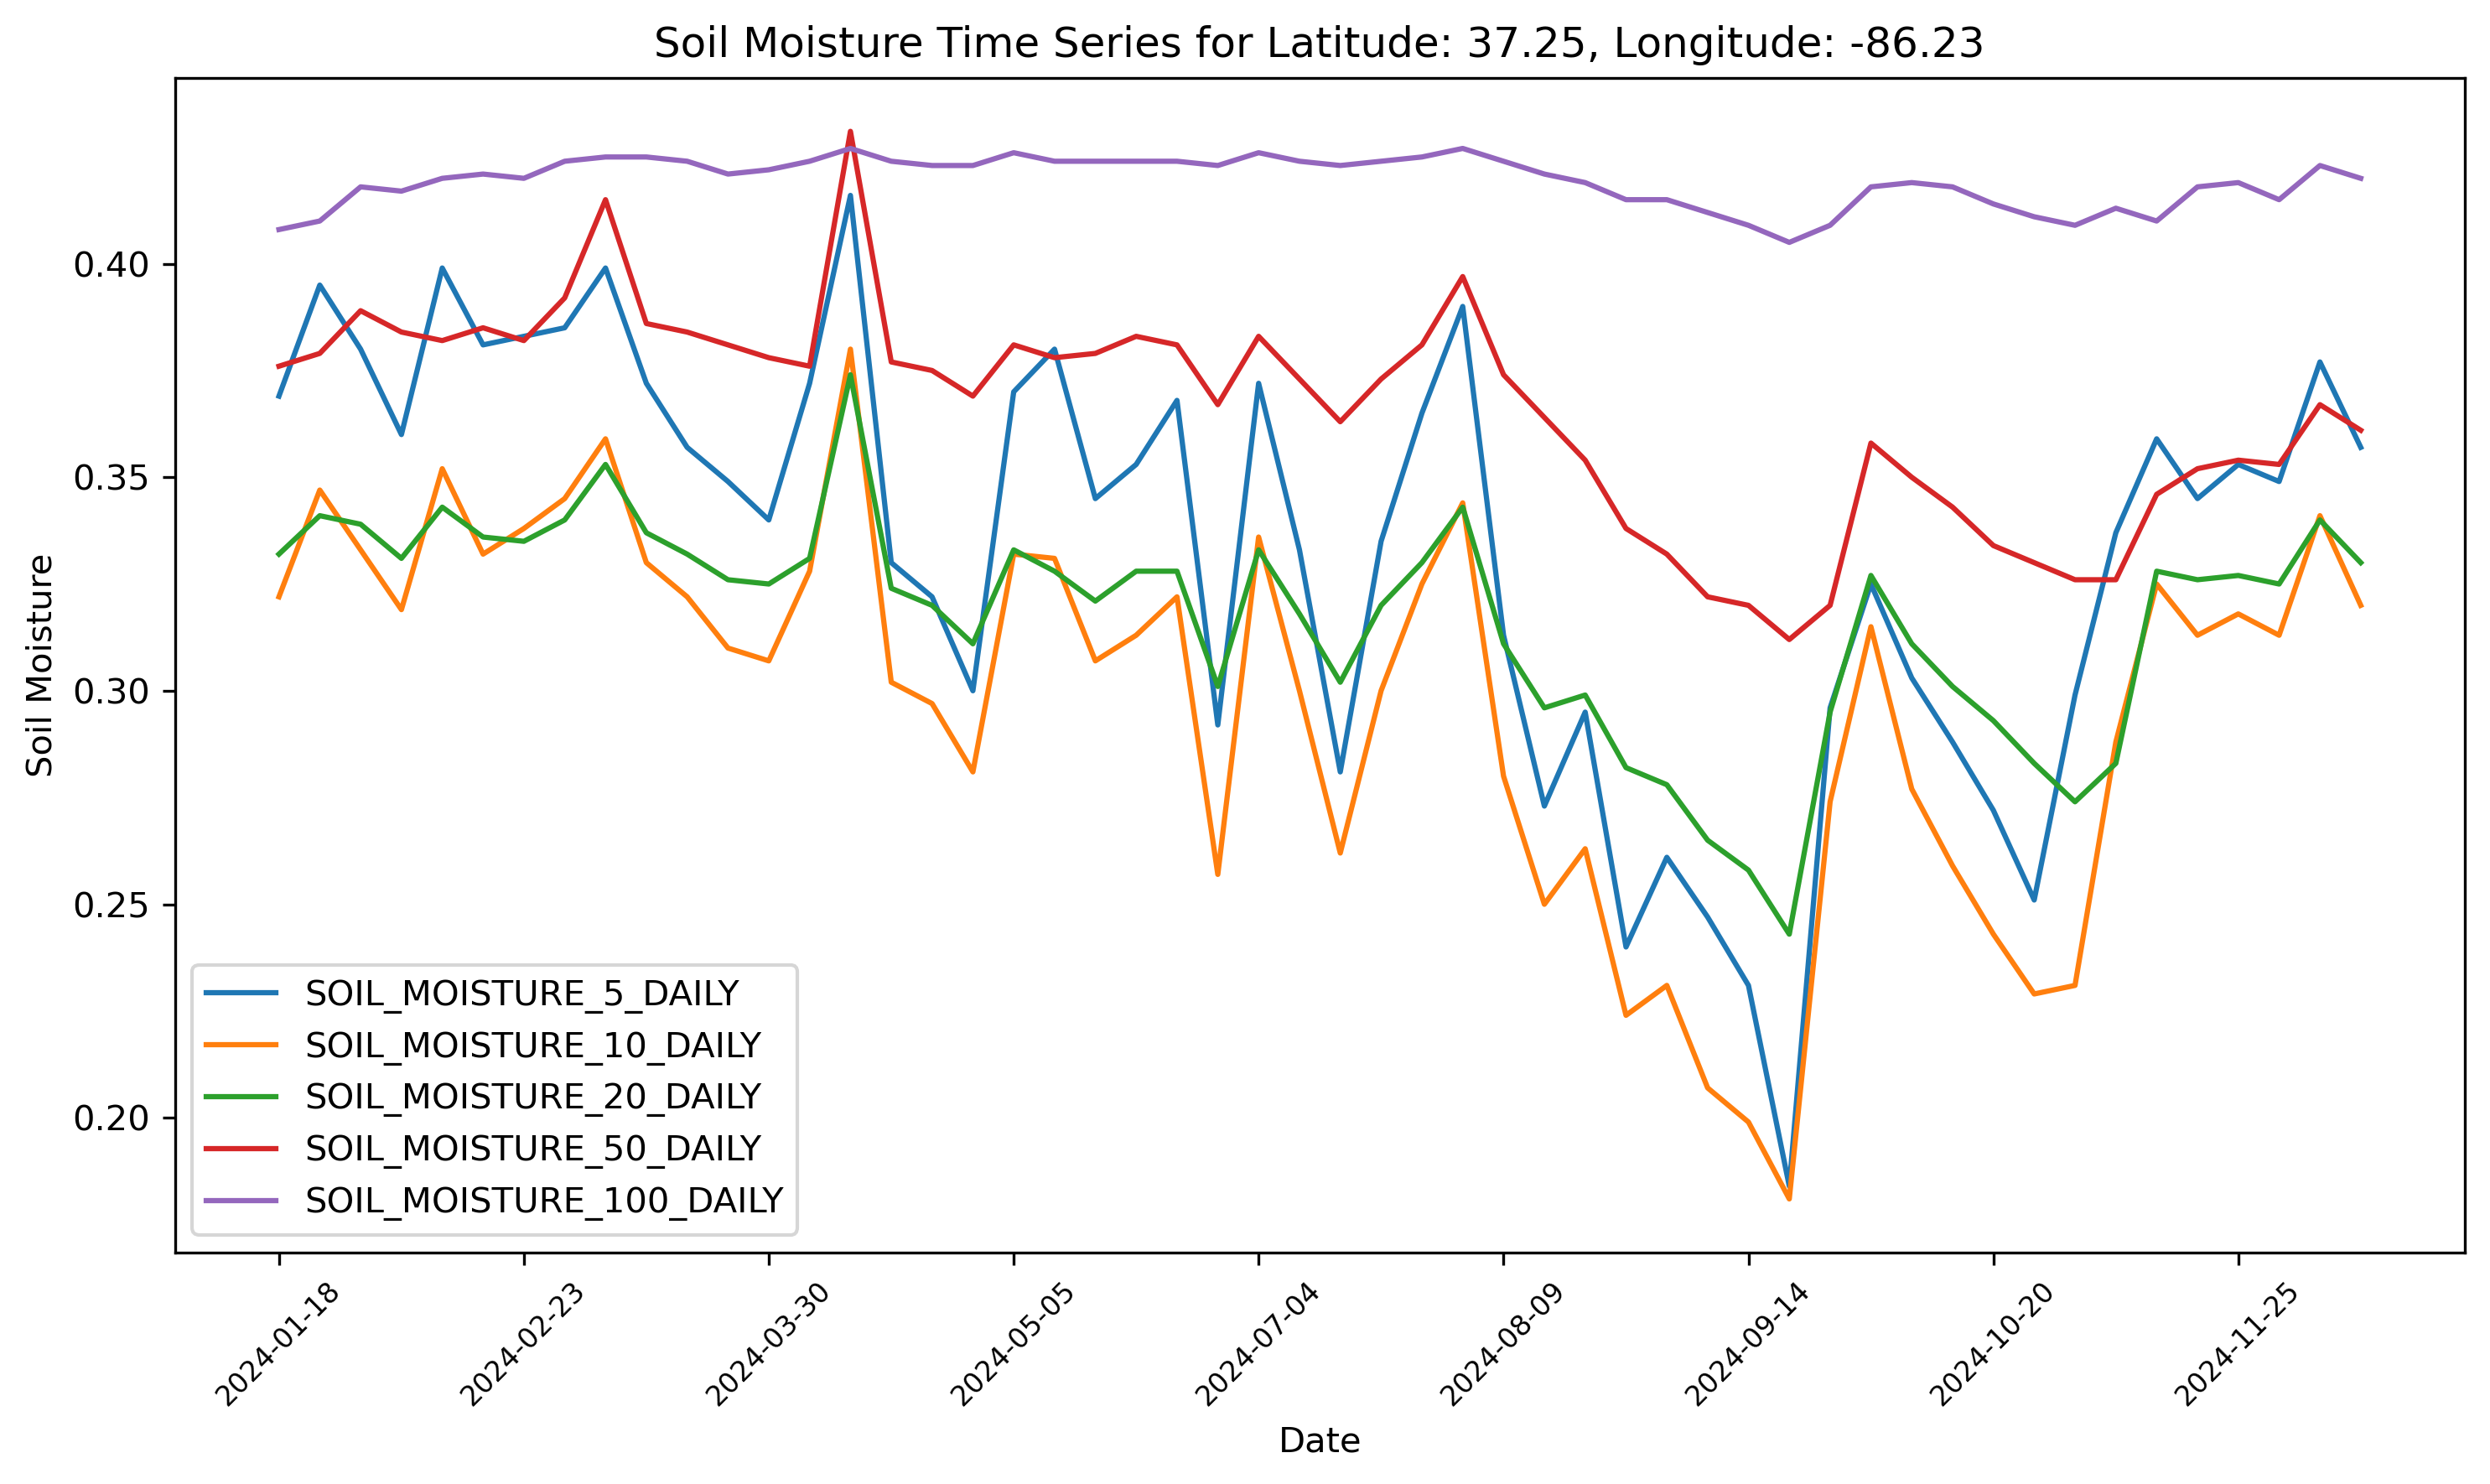

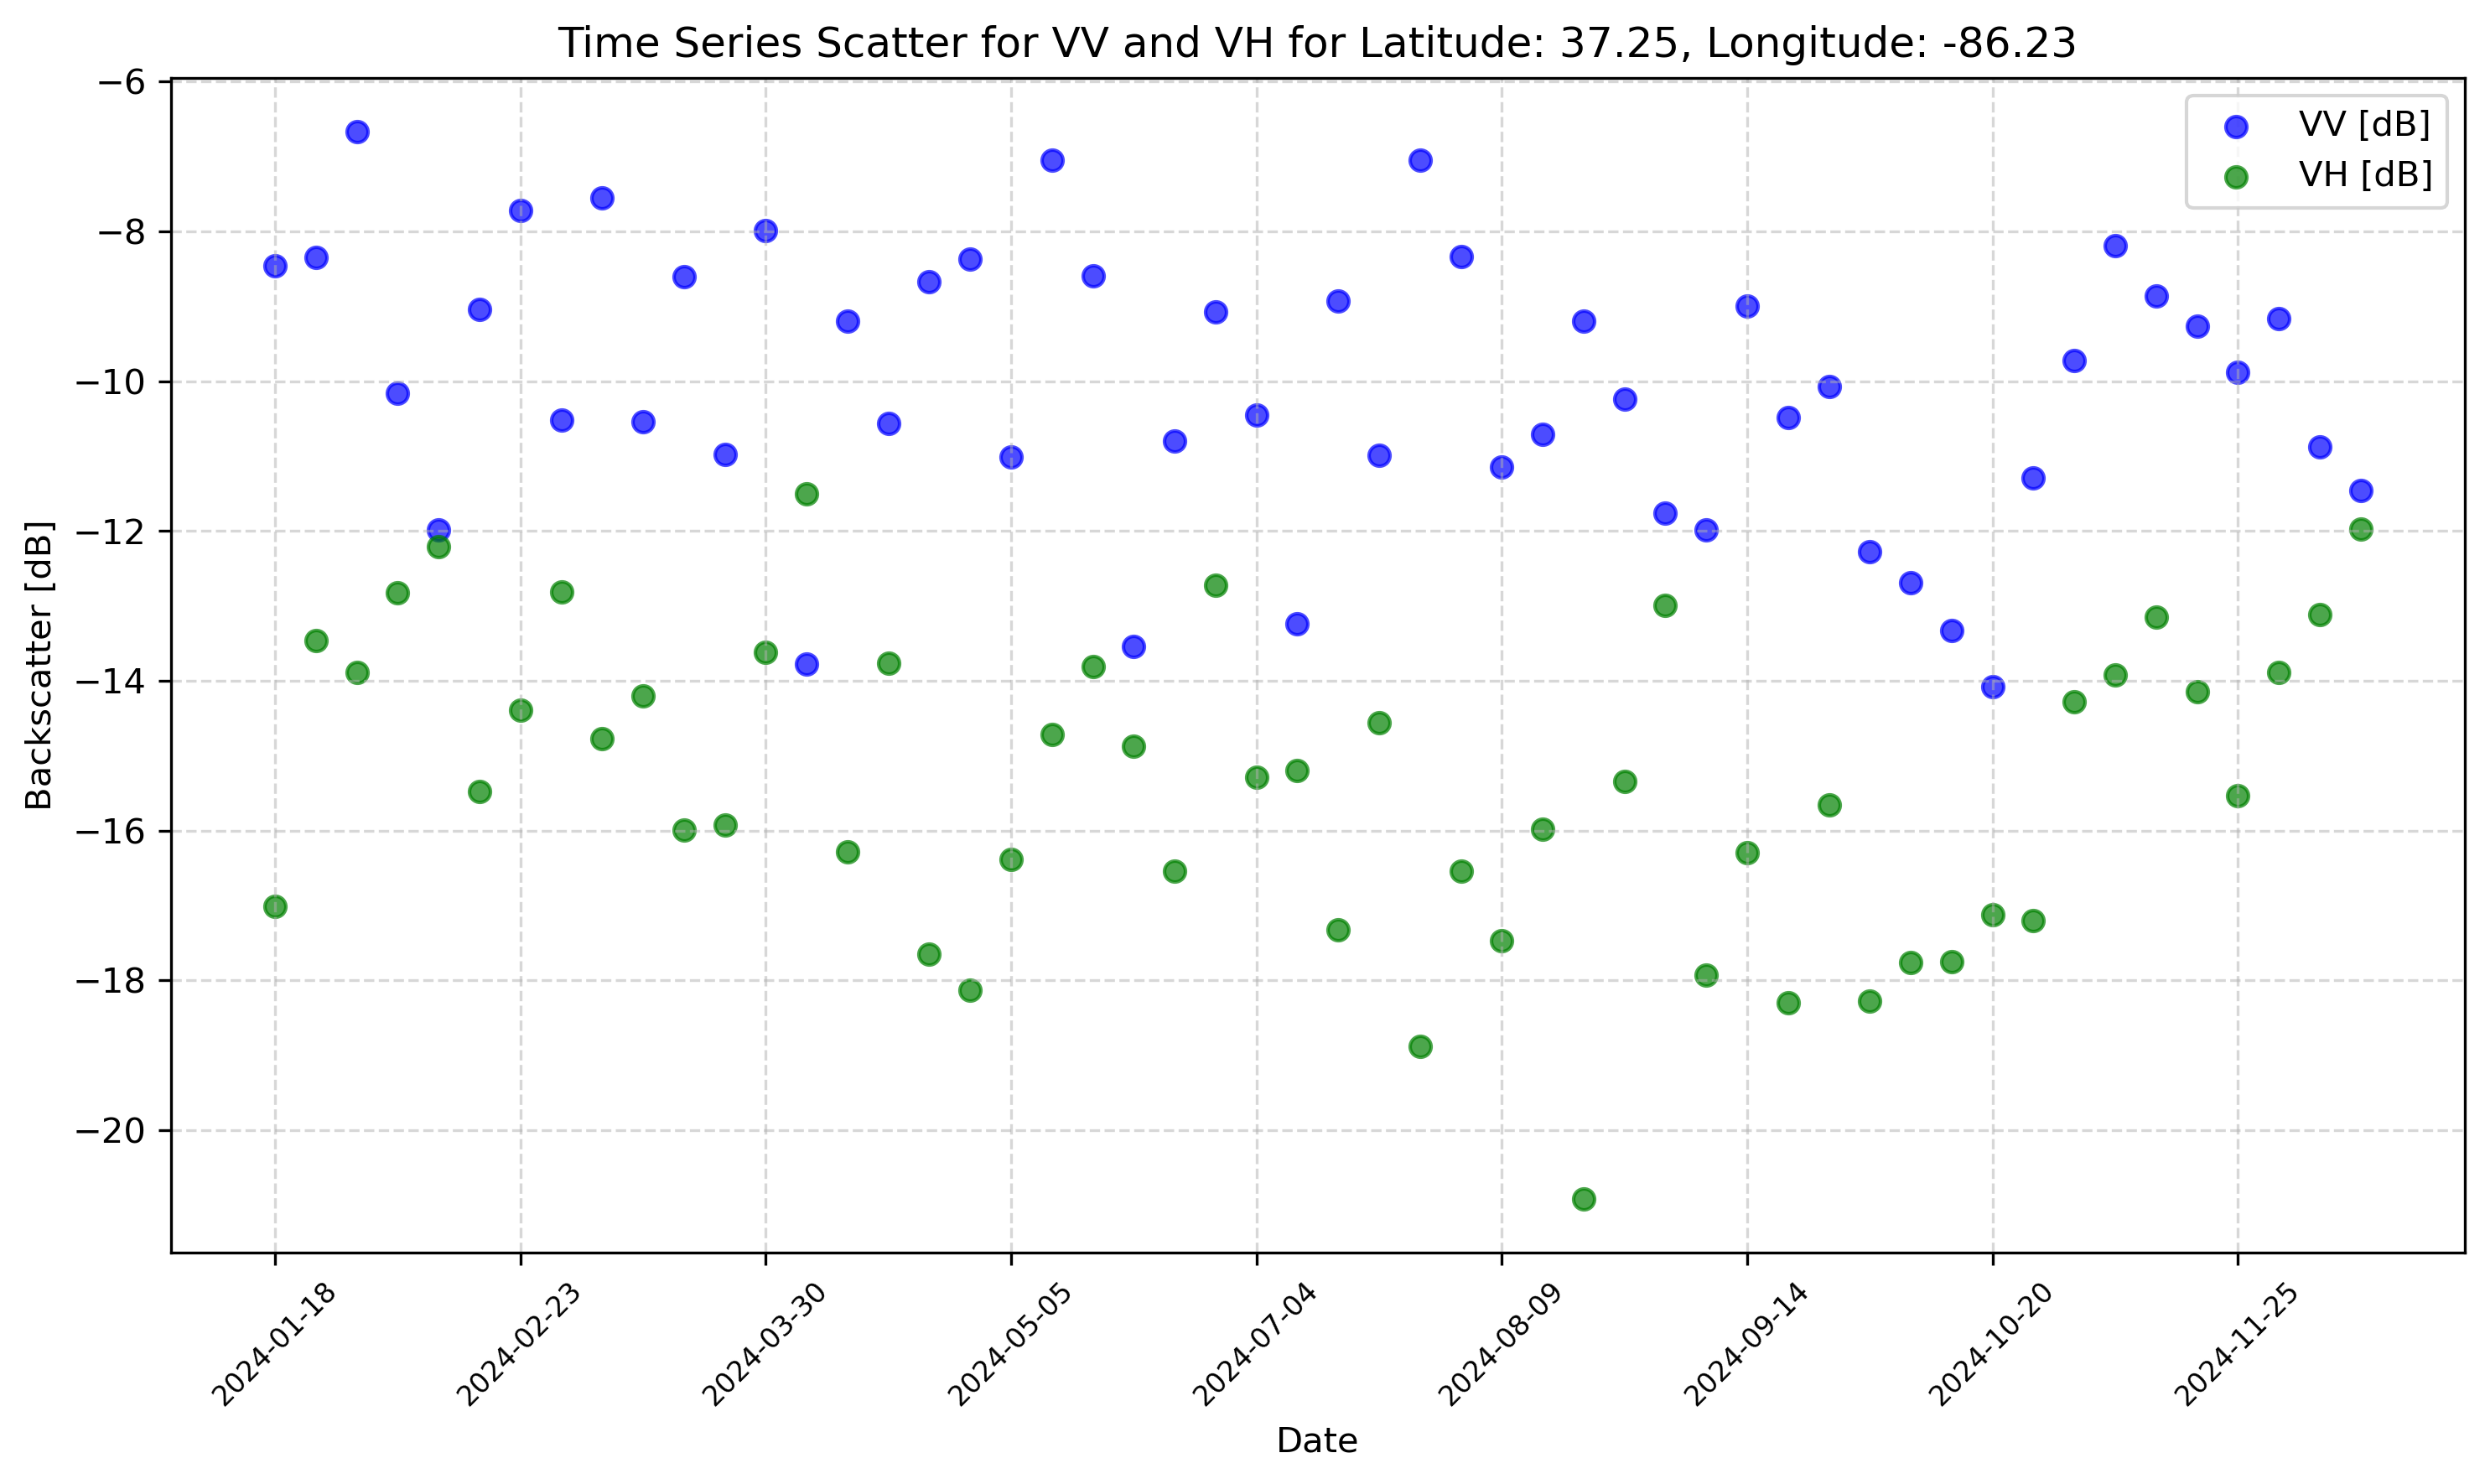

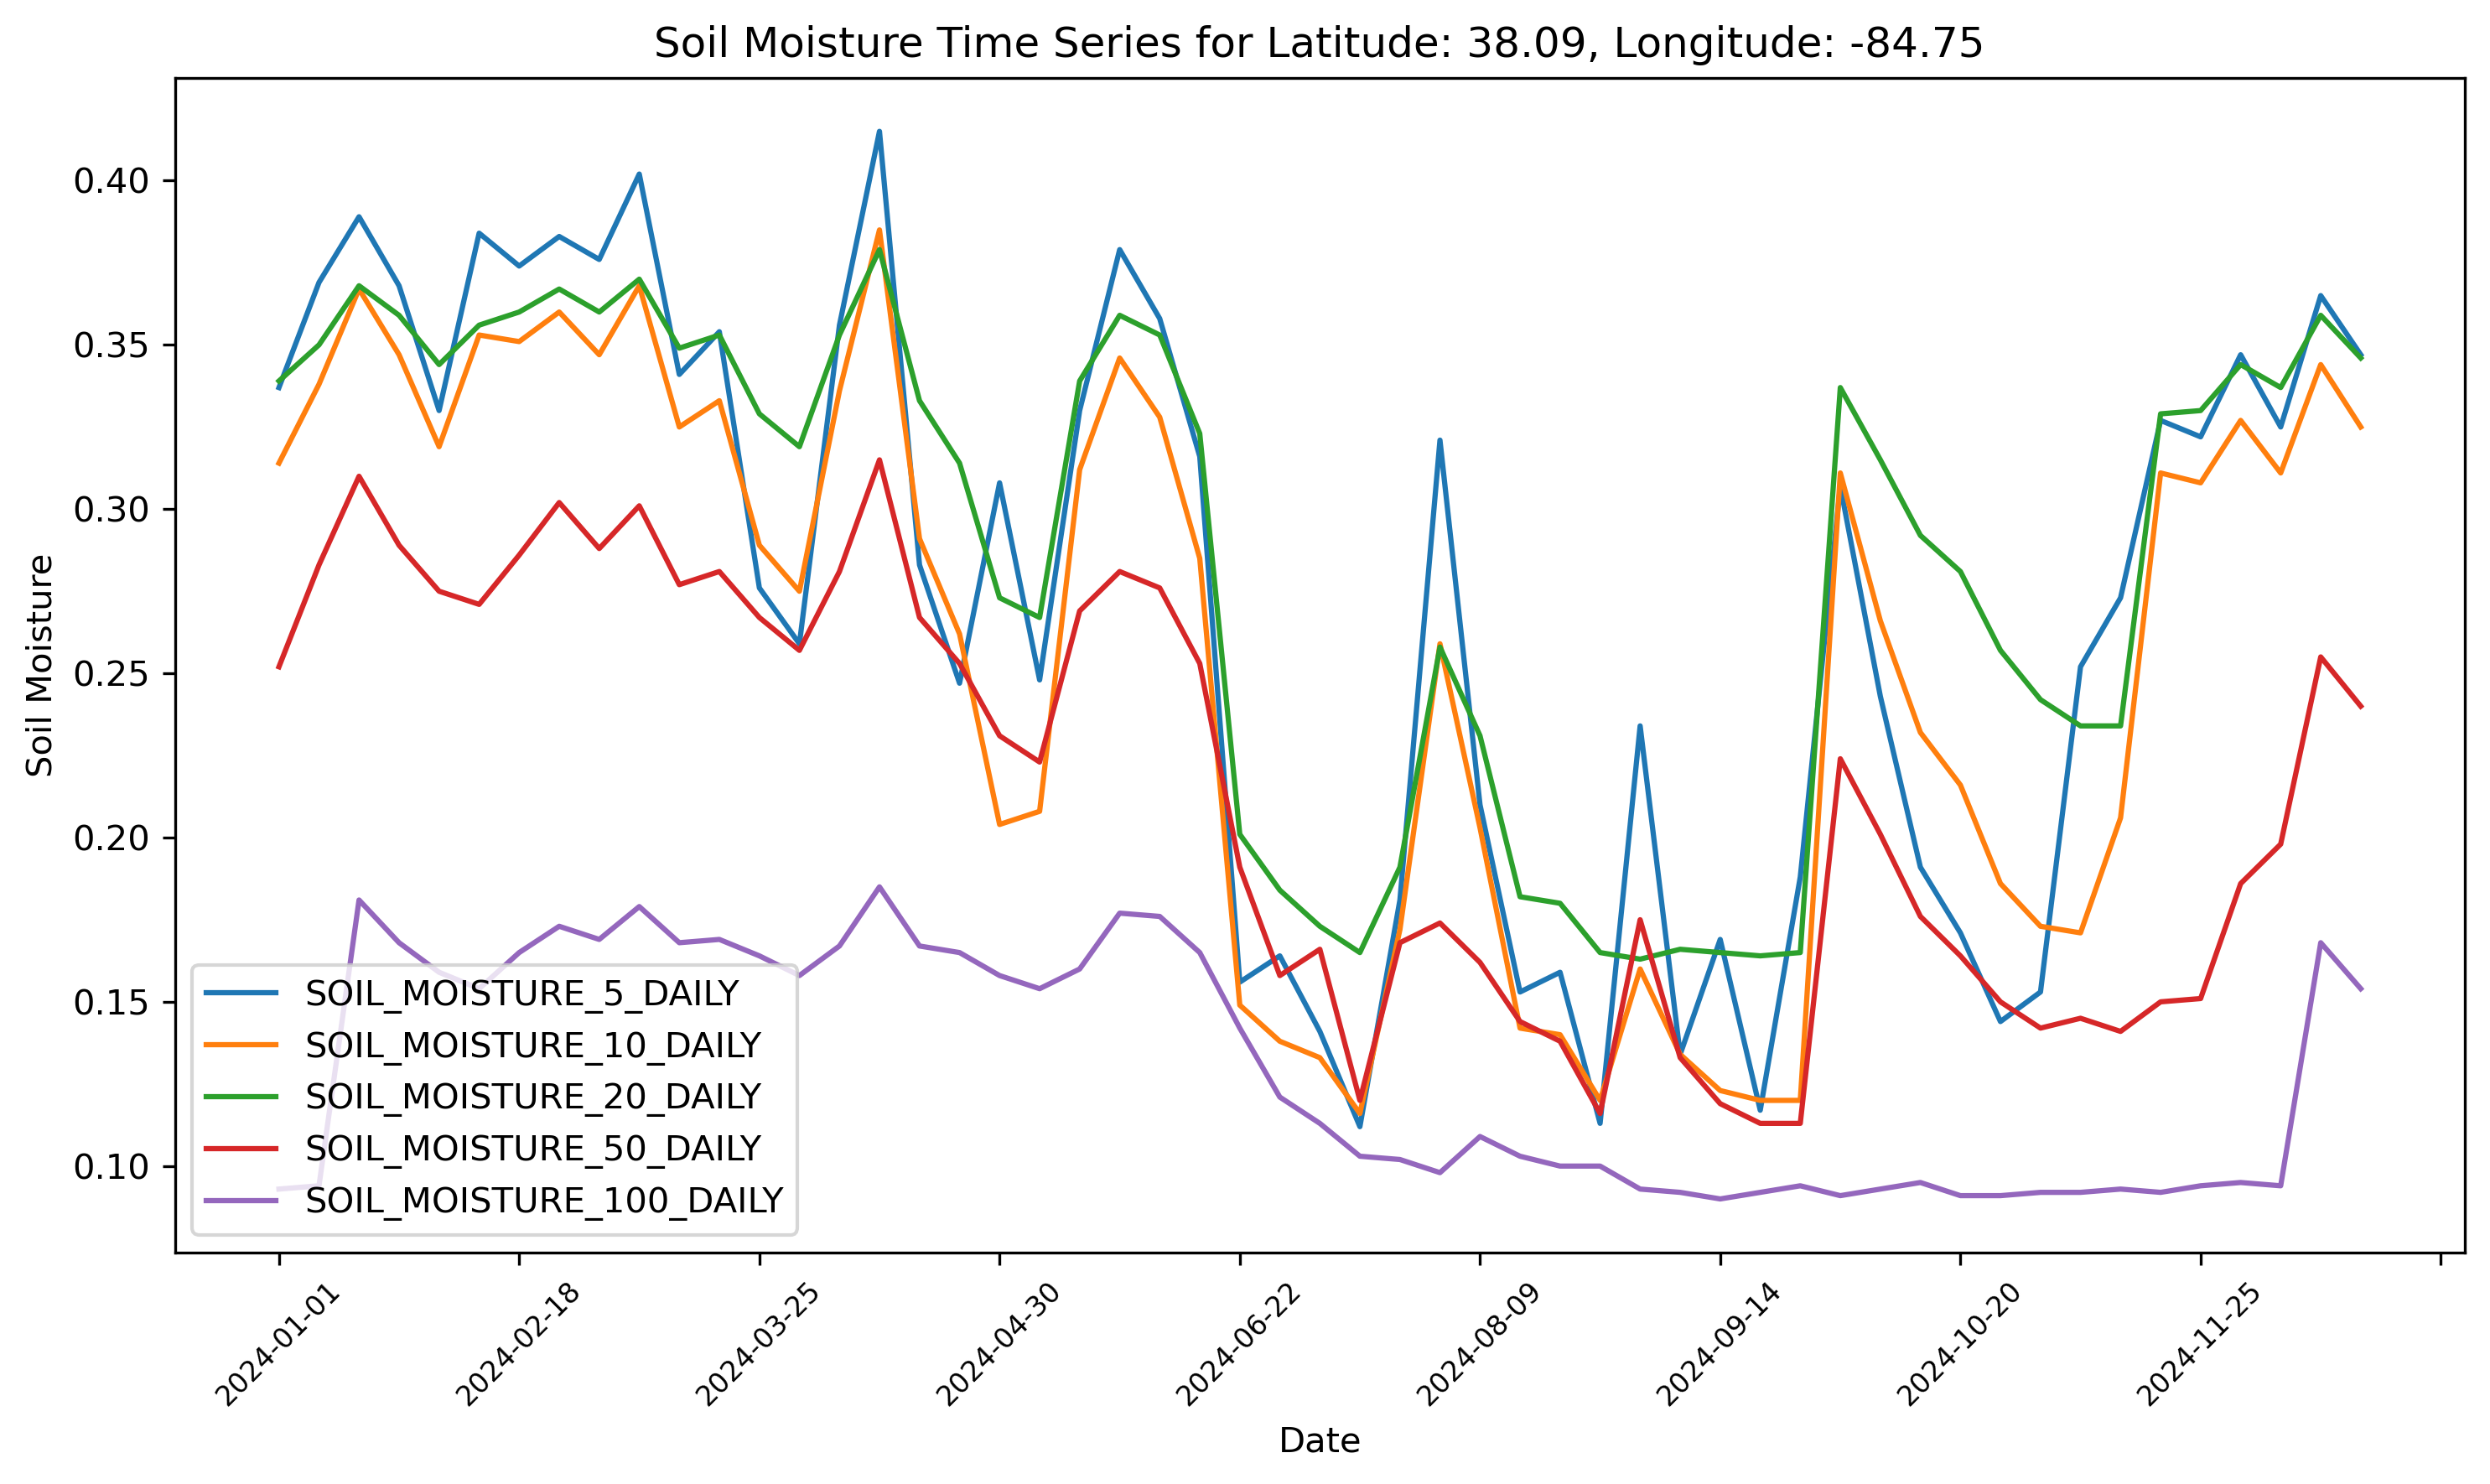

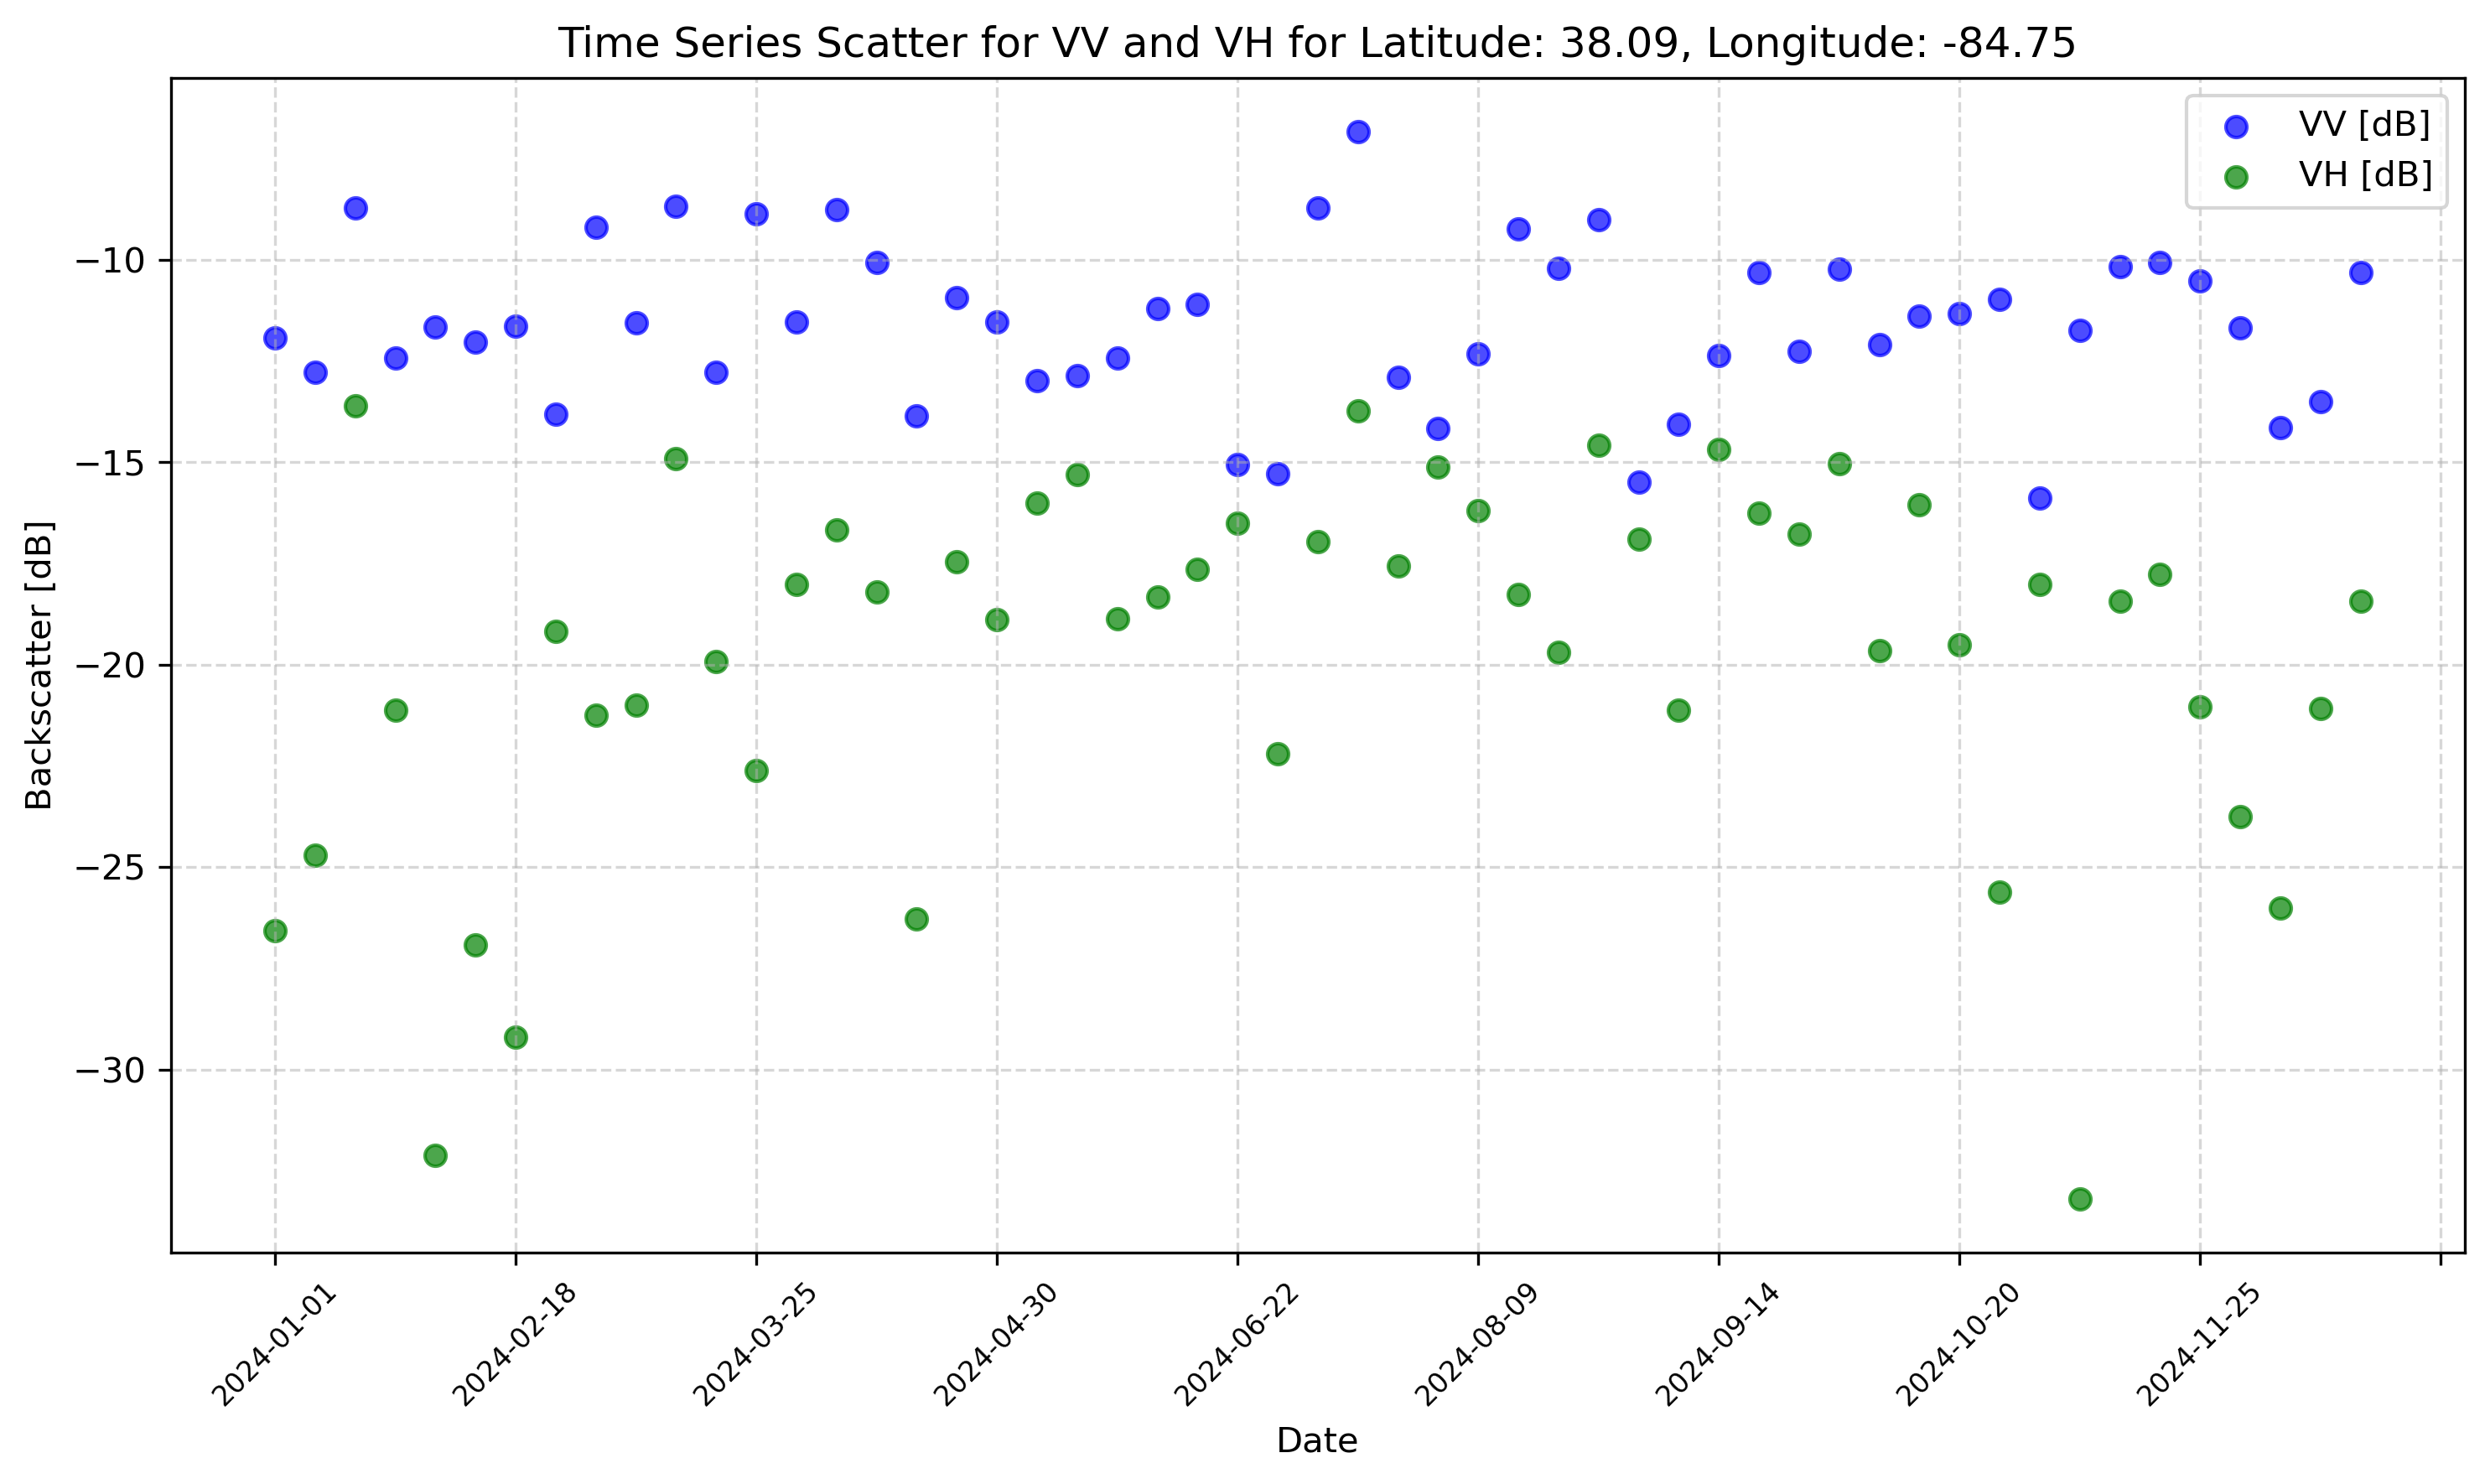

In [17]:
import matplotlib.pyplot as plt

# Group the data by unique latitude and longitude
grouped = ml_training_df.groupby(['latitude [°]', 'longitude [°]'])
# Define the soil moisture columns
soil_moisture_columns = [
	'SOIL_MOISTURE_5_DAILY', 'SOIL_MOISTURE_10_DAILY', 'SOIL_MOISTURE_20_DAILY',
	'SOIL_MOISTURE_50_DAILY', 'SOIL_MOISTURE_100_DAILY'
]

# Iterate through each group
for (lat, lon), group in grouped:
    # Sort the group by date
    group = group.sort_values(by='date')
    
    # Create a time series plot for soil moisture
    plt.figure(figsize=(10, 6), dpi=300)  # High resolution
    for col in soil_moisture_columns:
        plt.plot(group['date'], group[col], label=col)
    plt.title(f"Soil Moisture Time Series for Latitude: {lat}, Longitude: {lon}")
    plt.xlabel("Date")
    plt.ylabel("Soil Moisture")
    plt.xticks(rotation=45, fontsize=8)  # Rotate and adjust font size of x-ticks
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Increase spacing of x-ticks
    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
    
    # Create a time series scatter plot for VV and VH
    plt.figure(figsize=(10, 6), dpi=300)
    plt.scatter(group['date'], group['VV [dB]'], label='VV [dB]', alpha=0.7, color='blue')
    plt.scatter(group['date'], group['VH [dB]'], label='VH [dB]', alpha=0.7, color='green')
    plt.title(f"Time Series Scatter for VV and VH for Latitude: {lat}, Longitude: {lon}")
    plt.xlabel("Date")
    plt.ylabel("Backscatter [dB]")
    plt.xticks(rotation=45, fontsize=8)  # Rotate and adjust font size of x-ticks
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Increase spacing of x-ticks
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    
   
    

In [18]:
# Define the soil moisture columns
soil_moisture_columns = [
	'SOIL_MOISTURE_5_DAILY', 'SOIL_MOISTURE_10_DAILY', 'SOIL_MOISTURE_20_DAILY',
	'SOIL_MOISTURE_50_DAILY', 'SOIL_MOISTURE_100_DAILY'
]

# Select the required columns
columns_to_keep = ['VV [dB]', 'VH [dB]', 'angle [degrees]', 'precipitation [mm]', 'elevation [m]'] + soil_moisture_columns

# Create a new DataFrame with the selected columns
ml_training_selected = ml_training_df[columns_to_keep]

# Display the new DataFrame
print(ml_training_selected.head())

ml_training_selected.to_csv("Datasets/ML_Training_Selected.csv", index=False)

     VV [dB]    VH [dB]  angle [degrees]  precipitation [mm]  elevation [m]  \
0 -11.920238 -26.572714        30.446728            0.000000            258   
2 -12.778517 -24.697451        41.969181           15.178405            258   
4  -8.453159 -17.009127        33.165001            0.000000            231   
6  -8.351386 -13.462296        43.958626            4.296156            231   
7  -8.719026 -13.603382        30.446655           10.896753            258   

   SOIL_MOISTURE_5_DAILY  SOIL_MOISTURE_10_DAILY  SOIL_MOISTURE_20_DAILY  \
0                  0.337                   0.314                   0.339   
2                  0.369                   0.338                   0.350   
4                  0.369                   0.322                   0.332   
6                  0.395                   0.347                   0.341   
7                  0.389                   0.367                   0.368   

   SOIL_MOISTURE_50_DAILY  SOIL_MOISTURE_100_DAILY  
0              

In [19]:
# Add the feature VV [dB] - VH [dB]
ml_training_selected['VV-VH [dB]'] = ml_training_selected['VV [dB]'] - ml_training_selected['VH [dB]']

# Add the feature VV [dB] / VH [dB]
ml_training_selected['VV/VH [dB]'] = ml_training_selected['VV [dB]'] / ml_training_selected['VH [dB]']

# Display the updated DataFrame
print(ml_training_selected.head())

     VV [dB]    VH [dB]  angle [degrees]  precipitation [mm]  elevation [m]  \
0 -11.920238 -26.572714        30.446728            0.000000            258   
2 -12.778517 -24.697451        41.969181           15.178405            258   
4  -8.453159 -17.009127        33.165001            0.000000            231   
6  -8.351386 -13.462296        43.958626            4.296156            231   
7  -8.719026 -13.603382        30.446655           10.896753            258   

   SOIL_MOISTURE_5_DAILY  SOIL_MOISTURE_10_DAILY  SOIL_MOISTURE_20_DAILY  \
0                  0.337                   0.314                   0.339   
2                  0.369                   0.338                   0.350   
4                  0.369                   0.322                   0.332   
6                  0.395                   0.347                   0.341   
7                  0.389                   0.367                   0.368   

   SOIL_MOISTURE_50_DAILY  SOIL_MOISTURE_100_DAILY  VV-VH [dB]  VV/V

C:\Users\shish\AppData\Local\Temp\ipykernel_2808\2051826236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_training_selected['VV-VH [dB]'] = ml_training_selected['VV [dB]'] - ml_training_selected['VH [dB]']
C:\Users\shish\AppData\Local\Temp\ipykernel_2808\2051826236.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_training_selected['VV/VH [dB]'] = ml_training_selected['VV [dB]'] / ml_training_selected['VH [dB]']


In [20]:
# Rearrange the columns
columns_order = [
    'VV [dB]', 'VH [dB]', 'angle [degrees]', 'precipitation [mm]', 'elevation [m]', 
    'VV-VH [dB]', 'VV/VH [dB]', 
    'SOIL_MOISTURE_5_DAILY', 'SOIL_MOISTURE_10_DAILY', 'SOIL_MOISTURE_20_DAILY', 
    'SOIL_MOISTURE_50_DAILY', 'SOIL_MOISTURE_100_DAILY'
]
ml_training_selected = ml_training_selected[columns_order]

# Display the updated DataFrame
print(ml_training_selected.head())
ml_training_selected.to_csv("Datasets/ML_Training_Selected.csv", index=False)

     VV [dB]    VH [dB]  angle [degrees]  precipitation [mm]  elevation [m]  \
0 -11.920238 -26.572714        30.446728            0.000000            258   
2 -12.778517 -24.697451        41.969181           15.178405            258   
4  -8.453159 -17.009127        33.165001            0.000000            231   
6  -8.351386 -13.462296        43.958626            4.296156            231   
7  -8.719026 -13.603382        30.446655           10.896753            258   

   VV-VH [dB]  VV/VH [dB]  SOIL_MOISTURE_5_DAILY  SOIL_MOISTURE_10_DAILY  \
0   14.652476    0.448589                  0.337                   0.314   
2   11.918935    0.517402                  0.369                   0.338   
4    8.555968    0.496978                  0.369                   0.322   
6    5.110910    0.620354                  0.395                   0.347   
7    4.884356    0.640945                  0.389                   0.367   

   SOIL_MOISTURE_20_DAILY  SOIL_MOISTURE_50_DAILY  SOIL_MOISTURE_100